In [1]:
import sys
if 'google.colab' in sys.modules:  # colab特有の処理_2回目以降
  # Google Driveのマウント
  from google.colab import drive
  drive.mount('/content/drive')

  # ライブラリのパス指定
  sys.path.append('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/XX_modules')


Mounted at /content/drive


In [2]:
%cd
!mkdir .kaggle
!mkdir /content/model
!cp /content/drive/MyDrive/Colab_Files/kaggle-api/kaggle.json .kaggle/

/root


In [3]:
%env DL_PATH /content/055-051-train-08-02
%env DATASET_PATH calpis10000/055-051-train-08-02

!mkdir ${DL_PATH}
!kaggle datasets download -p ${DL_PATH} -d ${DATASET_PATH} --unzip

env: DL_PATH=/content/055-051-train-08-02
env: DATASET_PATH=calpis10000/055-051-train-08-02
100% 6.14G/6.15G [01:18<00:00, 106MB/s]
100% 6.15G/6.15G [01:18<00:00, 83.8MB/s]


In [ ]:
"""%env DL_PATH /content/model_054_04
%env DATASET_PATH calpis10000/054-train-04

!mkdir ${DL_PATH}
!kaggle datasets download -p ${DL_PATH} -d ${DATASET_PATH} --unzip"""

'%env DL_PATH /content/model_054_04\n%env DATASET_PATH calpis10000/054-train-04\n\n!mkdir ${DL_PATH}\n!kaggle datasets download -p ${DL_PATH} -d ${DATASET_PATH} --unzip'

In [ ]:
"""%env DL_PATH /content/model_054_05
%env DATASET_PATH calpis10000/054-train-05-3

!mkdir ${DL_PATH}
!kaggle datasets download -p ${DL_PATH} -d ${DATASET_PATH} --unzip"""

'%env DL_PATH /content/model_054_05\n%env DATASET_PATH calpis10000/054-train-05-3\n\n!mkdir ${DL_PATH}\n!kaggle datasets download -p ${DL_PATH} -d ${DATASET_PATH} --unzip'

In [ ]:
"""%env DL_PATH /content/model_053_02
%env DATASET_PATH calpis10000/053-train-02

!mkdir ${DL_PATH}
!kaggle datasets download -p ${DL_PATH} -d ${DATASET_PATH} --unzip"""

'%env DL_PATH /content/model_053_02\n%env DATASET_PATH calpis10000/053-train-02\n\n!mkdir ${DL_PATH}\n!kaggle datasets download -p ${DL_PATH} -d ${DATASET_PATH} --unzip'

In [13]:
# データセットをDriveから取得
!mkdir -p 'input'
!mkdir -p 'clrp-pre-trained'

# input
!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/00_input/commonlitreadabilityprize/' '/content/input/'

# 学習済み_roberta-large-256
!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/97_pre_trained/clrp_pretrained_manish_epoch5/pre-trained-roberta/clrp_roberta_large/' '/content/clrp-pre-trained'

# 学習済み_roberta-large-300
!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/97_pre_trained/clrp_roberta_large_300/clrp_roberta_large_300/clrp_roberta_large' '/content/clrp-pre-trained-300'

In [5]:
# input取得
from pathlib import Path
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = Path('../input/commonlitreadabilityprize/')

elif 'google.colab' in sys.modules: # Colab環境
    DATA_DIR = Path('/content/input/commonlitreadabilityprize')

else:
    DATA_DIR = Path('../00_input/commonlitreadabilityprize/')

In [6]:
# tokenizer
TOKENIZER_256 = '/content/clrp-pre-trained/clrp_roberta_large'
TOKENIZER_300 = '/content/clrp-pre-trained-300'

In [7]:
# pre-trained model
PRE_TRAINED_256 = '/content/clrp-pre-trained/clrp_roberta_large'
PRE_TRAINED_300= '/content/clrp-pre-trained-300'

In [8]:
UPLOAD_DIR = Path('/content/model')
EX_NO = 'calpis10000/055-051-train-08-02'  # 実験番号などを入れる、folderのpathにする
USERID = 'calpis10000'

In [9]:
import subprocess
import shlex

def gpuinfo():
    """
    Returns size of total GPU RAM and used GPU RAM.

    Parameters
    ----------
    None

    Returns
    -------
    info : dict
        Total GPU RAM in integer for key 'total_MiB'.
        Used GPU RAM in integer for key 'used_MiB'.
    """

    command = 'nvidia-smi -q -d MEMORY | sed -n "/FB Memory Usage/,/Free/p" | sed -e "1d" -e "4d" -e "s/ MiB//g" | cut -d ":" -f 2 | cut -c2-'
    commands = [shlex.split(part) for part in command.split(' | ')]
    for i, cmd in enumerate(commands):
        if i==0:
            res = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        else:
            res = subprocess.Popen(cmd, stdin=res.stdout, stdout=subprocess.PIPE)
    total, used = map(int, res.communicate()[0].decode('utf-8').strip().split('\n'))
    info = {'total_MiB':total, 'used_MiB':used}
    return info


# Overview
This nb is based on copy from https://www.kaggle.com/andretugan/lightweight-roberta-solution-in-pytorch .

Acknowledgments(from base nb): 
some ideas were taken from kernels by [Torch](https://www.kaggle.com/rhtsingh) and [Maunish](https://www.kaggle.com/maunish).

In [10]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW # optimizer
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup # scheduler
from pytorch_memlab import profile
import pytorch_memlab
from pytorch_memlab import MemReporter

from sklearn.model_selection import KFold, StratifiedKFold

import pickle
import gc
gc.enable()

In [11]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True# cudnnによる最適化で結果が変わらないためのおまじない 

In [14]:
# read train_df(kfold)
train_kf_df = pd.read_csv(DATA_DIR/"train_kfold.csv")

# Model_051-08

In [15]:
INF_MODEL_DIR = Path('/content/055-051-train-08-02')

NUM_FOLDS = 5 # K Fold
NUM_EPOCHS = 5 # Epochs
BATCH_SIZE = 12 # Batch Size
MAX_LEN = 248 # ベクトル長
EVAL_SCHEDULE = [(0.55, 64), (-1., 32)] # schedulerの何らかの設定？
ROBERTA_PATH = PRE_TRAINED_256 # roberta pre-trainedモデル(モデルとして指定)
TOKENIZER_PATH = PRE_TRAINED_256 # roberta pre-trainedモデル(Tokenizerとして指定)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # cudaがなければcpuを使えばいいじゃない

In [16]:
# tokenizerを指定
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# Dataset

In [17]:
# 前処理用
import string
import re
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text

def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [18]:
class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only # Testデータ用フラグ
        self.text = df.excerpt.tolist() # 分析対象カラムをlistにする。(分かち書きではなく、Seriesをlistへ変換するような処理)
        #self.text = [text.replace("\n", " ") for text in self.text] # 単語単位で分かち書きする場合
        self.text_len = text_normalization(df.excerpt).map(lambda x: [0 if i >= len(x.split(' ')) else len(x.split(' ')[i]) for i in range(132)])

        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32) # trainのみ、targetをtensorに変換
            self.standard_error = torch.tensor(df.standard_error.values, dtype=torch.float32) 

        self.encoded = tokenizer.batch_encode_plus( # textをtokenize
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True, # 最大長を超える文字は切り捨て
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index): # 変換結果を返す
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        input_len = torch.tensor(self.text_len.iloc[index], dtype=torch.float32)

        if self.inference_only:
            return (input_ids, attention_mask, input_len)            
        else:
            target = self.target[index]
            standard_error = self.standard_error[index]
            return (input_ids, attention_mask, input_len, target, standard_error)

In [19]:
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH) # pretrainedからconfigを読み込み
        config.update({"output_hidden_states":True, # config更新: embedding層を抽出
                       "hidden_dropout_prob": 0.0, # config更新: dropoutしない
                       "layer_norm_eps": 1e-7}) # config更新: layer normalizationのepsilon                      
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config) # cpuで処理する
            
        self.attention = nn.Sequential(# attentionレイヤー            
            nn.Linear(config.hidden_size, 512),      
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )

        self.mlm_layers = nn.Sequential(
            nn.Linear(132, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )

        self.regressor = nn.Sequential( # 出力レイヤー                    
            nn.Linear(config.hidden_size + 64, 2)                        
        )

    def forward(self, input_ids, attention_mask, input_len):
        roberta_output = self.roberta(input_ids=input_ids, # robertaに入力データを流し、出力としてrobertaモデル(layerの複合体)を得る
                                      attention_mask=attention_mask)     
        # attention_pooling
        last_hidden_state = roberta_output.hidden_states[-1] # robertaモデルの最後のlayerを得る
        weights = self.attention(last_hidden_state) # robertaの最後のlayerをattentionへ入力し、出力として重みを得る                
        context_vector = torch.sum(weights * last_hidden_state, dim=1) # 重み×最後の層を足し合わせて文書ベクトルとする。

        # word_length_conv1d
        #input_chnl = input_len.unsqueeze(1)
        #conv1_layers = self.conv1_layers(input_chnl)
        #conv1_layers_v = conv1_layers.view(conv1_layers.size(0),-1)

        # word_length_mlm
        mlm_layers = self.mlm_layers(input_len)


        # https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently
        # last_hidden_state = roberta_output[0]
        # input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        # sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        # sum_mask = input_mask_expanded.sum(1)
        # sum_mask = torch.clamp(sum_mask, min=1e-9)
        # mean_embeddings = sum_embeddings / sum_mask

        # concat_embeddings
        cat_embeddings = torch.cat([context_vector, mlm_layers], dim=1)        
        return self.regressor(cat_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する
        
        # Now we reduce the context vector to the prediction score.
        #return self.regressor(mean_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する

In [20]:
# 推論結果を返す
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval() # evalモード(dropout, batch_normしない)

    result = np.zeros(len(data_loader.dataset)) # 結果をdataset長のzero配列として用意
    index = 0
    
    with torch.no_grad(): # 勾配の計算をしないblock(inputすると、現状の重みによる推論結果を返す)
        for batch_num, (input_ids, attention_mask, input_len) in enumerate(data_loader): # data_loaderからbatchごとにinputを得る
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            input_len = input_len.to(DEVICE)
                        
            output = model(input_ids, attention_mask, input_len) # modelにinputを入力し、予測結果を得る。

            result[index : index + output[:,0].shape[0]] = output[:,0].flatten().to("cpu") # result[index ~ predの長さ]へ、予測結果を格納
            index += output.shape[0] # indexを更新

    return result # 全batchで推論が終わったら、結果を返す

In [21]:
# validation再実行_予測結果取得
all_predictions = np.zeros(len(train_kf_df)) # 推論結果について、「fold　× 推論df」のzero行列で枠を作る

for fold_ in sorted(train_kf_df['kfold'].unique()):
    model_path = INF_MODEL_DIR/f"model_{fold_ + 1}.pth" # 対応するモデルを読む
    print(f"\nUsing {model_path}")

    val_idx = train_kf_df['kfold'] == fold_
    val_df = train_kf_df[val_idx]
    val_dataset = LitDataset(val_df, inference_only=True) # TestのDataset(何で、もう一回作るのだろう？)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          drop_last=False, shuffle=False, num_workers=2) # TestのDataLoader

    model = LitModel()
    model.load_state_dict(torch.load(model_path))    # 対応するモデルから、重みを読み込む
    model.to(DEVICE) # モデルをDEVICEへぶち込む

    all_predictions[val_idx] = predict(model, val_loader) # 推論結果行列の対象列に、推論結果を入力(以後、繰り返し)

    del model
    gc.collect()



Using /content/055-051-train-08-02/model_1.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/055-051-train-08-02/model_2.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/055-051-train-08-02/model_3.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/055-051-train-08-02/model_4.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/055-051-train-08-02/model_5.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi

In [22]:
from sklearn.metrics import mean_squared_error
import math
np.sqrt(mean_squared_error(train_kf_df.target.values, all_predictions))

0.4823873604679941

In [29]:
train_kf_df['pred'] = all_predictions
fold = 1
tg_true = train_kf_df[train_kf_df['kfold']==fold]['target'].values
tg_pred = train_kf_df[train_kf_df['kfold']==fold]['pred'].values
np.sqrt(mean_squared_error(tg_true, tg_pred))

0.47247669991275654

In [30]:
train_kf_df['diff_sq'] = (train_kf_df['target'] - train_kf_df['pred'])**2

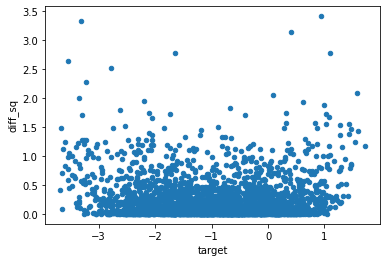

In [36]:
train_kf_df.plot(kind='scatter', x='target', y='diff_sq')

In [85]:
# ハズレ値のdiffを他と同程度に抑えられたら、どのくらいのRMSEになるか？
# (簡単のため、ハズレ値を除外したRMSEを計算する)
thr_ = 2.0 
kfdf_tmp = train_kf_df[train_kf_df['diff_sq'] < thr_].copy()

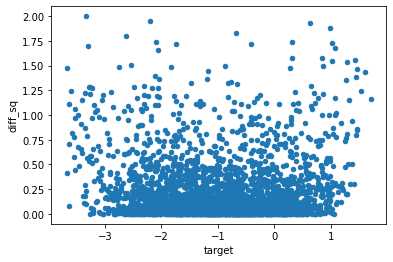

In [86]:
kfdf_tmp.plot(kind='scatter', x='target', y='diff_sq')

In [87]:
np.sqrt(mean_squared_error(kfdf_tmp.target.values, kfdf_tmp.pred.values))

0.4732325428398776

In [89]:
# 二乗誤差が2.0を超えるカラム
thr_ = 2.0 
train_kf_df[train_kf_df['diff_sq'] > thr_]

,id,url_legal,license,excerpt,target,standard_error,kfold,bins_tg,bins_std,bins,pred,diff_sq
141,bcd734621,NaN,NaN,Midas was enjoying himself in his treasure-roo...,0.943021,0.537713,0,10,5,105,-0.904493,3.413308
304,f04e03fd8,NaN,NaN,"Jupiter, two hours high, was the herald of the...",-3.229761,0.551435,1,0,6,6,-1.718621,2.283544
990,afeb324bd,NaN,NaN,"On the morning of the 20th of March, a long se...",0.401053,0.481889,0,9,2,92,-1.368975,3.132997
1152,03b761fd9,https://simple.wikipedia.org/wiki/Larva,CC BY-SA 3.0 and GFDL,Probably the most widely accepted theory expla...,-2.778515,0.533111,2,1,5,15,-1.189867,2.523802
1314,85b41606e,NaN,NaN,"As soon as the plate is dry, a positive cliché...",-3.543987,0.609348,3,0,9,9,-1.918570,2.641982
1412,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776,1,11,10,1110,0.137455,2.092049
1879,4ac78e5c3,NaN,NaN,The next morning Ethel Hollister walked up to ...,-1.639354,0.526015,3,4,5,45,0.025236,2.770857
1944,04ade0eb2,NaN,NaN,"While I was hailing the brig, I spied a tract ...",-3.315282,0.544735,2,0,6,6,-1.489423,3.333764
2124,76f92b721,NaN,NaN,"The biggest desert in the world is in Africa, ...",1.103341,0.553751,2,10,6,106,-0.564534,2.781807
2322,2b4024021,NaN,NaN,"They came to a garden, inclosed by a low wall ...",0.090335,0.497793,1,8,3,83,-1.341432,2.049955


In [103]:
# 二乗誤差が2.0を超える文章
thr_ = 2.0 
tmp_df = train_kf_df[train_kf_df['diff_sq'] > thr_].copy()
for i in tmp_df.index:
  print(tmp_df.loc[i].target)
  #print(tmp_df.loc[i].standard_error)
  print(tmp_df.loc[i].pred)
  print(tmp_df.loc[i].excerpt)
  print('--------------------------')

0.943020903
-0.9044932126998901
Midas was enjoying himself in his treasure-room, one day, as usual, when he perceived a shadow fall over the heaps of gold; and, looking suddenly up, what should he behold but the figure of a stranger, standing in the bright and narrow sunbeam! It was a young man, with a cheerful and ruddy face. Whether it was that the imagination of King Midas threw a yellow tinge over everything, or whatever the cause might be, he could not help fancying that the smile with which the stranger regarded him had a kind of golden radiance in it. Certainly, although his figure intercepted the sunshine, there was now a brighter gleam upon all the piled-up treasures than before. Even the remotest corners had their share of it, and were lighted up, when the stranger smiled, as with tips of flame and sparkles of fire.
--------------------------
-3.229761439
-1.7186214923858643
Jupiter, two hours high, was the herald of the day; the Pleiades, just above the horizon, shed their s

In [155]:
text = tmp_df.loc[2830].excerpt

KeyError: ignored

In [108]:
text.split(.)

['Jupiter, two hours high, was the herald of the day; the Pleiades, just above the horizon, shed their sweet influence in the east; Lyra sparkled near the zenith; Andromeda veiled her newly discovered glories from the naked eye in the south; the steady Pointers, far beneath the pole, looked meekly up from the depths of the north to their sovereign',
 '\nSuch was the glorious spectacle as I entered the train',
 ' As we proceeded, the timid approach of twilight became more perceptible; the intense blue of the sky began to soften; the smaller stars, like little children, went first to rest; the sister-beams of the Pleiades soon melted together; but the bright constellations of the west and north remained unchanged',
 ' Steadily the wondrous transfiguration went on',
 ' Hands of angels, hidden from mortal eyes, shifted the scenery of the heavens; the glories of night dissolved into the glories of the dawn',
 '']

In [109]:
df = train_kf_df.copy()

In [157]:
df['target'][2830]

-3.164808116

In [116]:
sentences = df['excerpt'].map(lambda x: x.split('.'))

In [152]:
sentences.map(lambda x: len(x)).max()

35

In [122]:
# センテンス_文字長
[len(i) for i in sentences[0]]

[64, 108, 49, 197, 148, 76, 30, 44, 67, 70, 83, 66, 108, 0]

In [138]:
# センテンスを単語のリストに変換
sentences_list = sentences.map(lambda x: [text_prepare(i).split(' ') for i in x])

In [141]:
[len(i) for i in sentences[0]]

[64, 108, 49, 197, 148, 76, 30, 44, 67, 70, 83, 66, 108, 0]

In [153]:
sentences.map(lambda x: [0 if i >= len(x) else len(x[i]) for i in range(35)])

0       [64, 108, 49, 197, 148, 76, 30, 44, 67, 70, 83...
1       [63, 138, 31, 118, 97, 144, 134, 135, 0, 0, 0,...
2       [108, 77, 113, 176, 250, 257, 0, 0, 0, 0, 0, 0...
3       [181, 100, 68, 167, 154, 123, 162, 0, 0, 0, 0,...
4       [78, 118, 119, 115, 94, 306, 67, 0, 0, 0, 0, 0...
                              ...                        
2828    [35, 129, 45, 46, 50, 114, 98, 145, 38, 271, 1...
2829    [216, 106, 51, 206, 159, 157, 0, 0, 0, 0, 0, 0...
2830    [137, 75, 195, 340, 91, 171, 0, 0, 0, 0, 0, 0,...
2831    [173, 351, 146, 154, 140, 146, 0, 0, 0, 0, 0, ...
2832    [51, 84, 103, 179, 217, 159, 0, 0, 0, 0, 0, 0,...
Name: excerpt, Length: 2833, dtype: object

In [ ]:
.map(lambda x: [0 if i >= len(x.split(' ')) else len(x.split(' ')[i]) for i in range(132)])

In [ ]:
# センテンス_単語数
sentences_list = sentences.map(lambda x: [text_prepare(i).split(' ') for i in x])

In [154]:
df['excerpt'].map(lambda x: x.split('.')).map(lambda x: [0 if i >= len(x) else len(x[i]) for i in range(35)])

0       [64, 108, 49, 197, 148, 76, 30, 44, 67, 70, 83...
1       [63, 138, 31, 118, 97, 144, 134, 135, 0, 0, 0,...
2       [108, 77, 113, 176, 250, 257, 0, 0, 0, 0, 0, 0...
3       [181, 100, 68, 167, 154, 123, 162, 0, 0, 0, 0,...
4       [78, 118, 119, 115, 94, 306, 67, 0, 0, 0, 0, 0...
                              ...                        
2828    [35, 129, 45, 46, 50, 114, 98, 145, 38, 271, 1...
2829    [216, 106, 51, 206, 159, 157, 0, 0, 0, 0, 0, 0...
2830    [137, 75, 195, 340, 91, 171, 0, 0, 0, 0, 0, 0,...
2831    [173, 351, 146, 154, 140, 146, 0, 0, 0, 0, 0, ...
2832    [51, 84, 103, 179, 217, 159, 0, 0, 0, 0, 0, 0,...
Name: excerpt, Length: 2833, dtype: object

In [158]:
# センテンス特徴付きのデータセット
class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only # Testデータ用フラグ
        self.text = df.excerpt.tolist() # 分析対象カラムをlistにする。(分かち書きではなく、Seriesをlistへ変換するような処理)
        #self.text = [text.replace("\n", " ") for text in self.text] # 単語単位で分かち書きする場合
        self.text_len = text_normalization(df.excerpt).map(lambda x: [0 if i >= len(x.split(' ')) else len(x.split(' ')[i]) for i in range(132)])
        self.sentences = df['excerpt'].map(lambda x: x.split('.')).map(lambda x: [0 if i >= len(x) else len(x[i]) for i in range(35)])

        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32) # trainのみ、targetをtensorに変換
            self.standard_error = torch.tensor(df.standard_error.values, dtype=torch.float32) 

        self.encoded = tokenizer.batch_encode_plus( # textをtokenize
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True, # 最大長を超える文字は切り捨て
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index): # 変換結果を返す
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        input_len = torch.tensor(self.text_len.iloc[index], dtype=torch.float32)
        input_sentence = torch.tensor(self.sentences.iloc[index], dtype=torch.float32)

        if self.inference_only:
            return (input_ids, attention_mask, input_len, input_sentence)            
        else:
            target = self.target[index]
            standard_error = self.standard_error[index]
            return (input_ids, attention_mask, input_len, input_sentence, target, standard_error)

In [160]:
litds = LitDataset(train_kf_df)

In [170]:
litds[304][3]

tensor([347.,  55., 305.,  46., 138.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])